In [1]:
import ee

ee.Authenticate()


True

In [ ]:
import random
import time

import ee

# Initialize Earth Engine
ee.Initialize(project='ee-felixlundfrandsen')

# Define region of interest
roi = ee.Geometry.Rectangle([-120.0, 37.0, -119.5, 37.5])  # ~55 km x 55 km

# Define tile size in meters (256x256 pixels at 0.6m resolution)
grid_size_meters = 153.6

# Generate fixed-size tiles over the ROI
def create_tiles(roi, grid_size_meters):
    tiles = []
    coords = roi.bounds().coordinates().getInfo()[0]
    lon_min, lat_min = coords[0]
    lon_max, lat_max = coords[2]

    deg_per_meter = 1 / 111320
    step = grid_size_meters * deg_per_meter

    num_tiles_x = int((lon_max - lon_min) / step)
    num_tiles_y = int((lat_max - lat_min) / step)

    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            lon1 = lon_min + i * step
            lat1 = lat_min + j * step
            lon2 = lon1 + step
            lat2 = lat1 + step
            bbox = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])
            tiles.append(bbox)

    return tiles

# Create and select 100 random tiles
tiles = create_tiles(roi, grid_size_meters)
random.shuffle(tiles)
tiles = tiles[:100]

# Define image acquisition dates
timestamps = [
    "2004-07-05", "2006-07-07", "2009-06-22",
    "2012-06-28", "2016-06-30", "2020-06-26", "2022-08-10"
]

# Export configuration
scale = 0.6
folder_name = "EarthEngine_NAIP_MultiTiles"

# Select closest image within ±180 days of target date
def get_naip_image(target_date, tile):
    target = ee.Date(target_date)
    start = target.advance(-180, 'day')
    end = target.advance(180, 'day')

    collection = ee.ImageCollection("USDA/NAIP/DOQQ") \
        .filterDate(start, end) \
        .filterBounds(tile) \
        .map(lambda img: img.set("date_diff", img.date().difference(target, 'day').abs())) \
        .sort("date_diff")

    return collection.first()

# Export imagery for each tile and timestamp
for tile_index, tile in enumerate(tiles):
    area_id = f"area_{str(tile_index).zfill(3)}"

    for date in timestamps:
        year = date[:4]
        file_prefix = f"{area_id}_{year}_{date.replace('-', '')}"

        image = get_naip_image(date, tile)

        if image:
            image = image.select(['R', 'G', 'B'])

            task = ee.batch.Export.image.toDrive(
                image=image.clip(tile),
                description=file_prefix,
                folder=folder_name,
                fileNamePrefix=file_prefix,
                region=tile,
                crs='EPSG:4326',
                scale=scale,
                maxPixels=1e9
            )

            task.start()
            print(f"Started export: {file_prefix}")
        else:
            print(f"No image found for {file_prefix}, skipping...")

print("\nAll export tasks submitted. Monitor progress at https://code.earthengine.google.com/tasks")


🚀 Started export: area_000_2004_20040705
🚀 Started export: area_000_2006_20060707
🚀 Started export: area_000_2009_20090622
🚀 Started export: area_000_2012_20120628
🚀 Started export: area_000_2016_20160630
🚀 Started export: area_000_2020_20200626
🚀 Started export: area_000_2022_20220810
🚀 Started export: area_001_2004_20040705
🚀 Started export: area_001_2006_20060707
🚀 Started export: area_001_2009_20090622
🚀 Started export: area_001_2012_20120628
🚀 Started export: area_001_2016_20160630
🚀 Started export: area_001_2020_20200626
🚀 Started export: area_001_2022_20220810
🚀 Started export: area_002_2004_20040705
🚀 Started export: area_002_2006_20060707
🚀 Started export: area_002_2009_20090622
🚀 Started export: area_002_2012_20120628
🚀 Started export: area_002_2016_20160630
🚀 Started export: area_002_2020_20200626
🚀 Started export: area_002_2022_20220810
🚀 Started export: area_003_2004_20040705
🚀 Started export: area_003_2006_20060707
🚀 Started export: area_003_2009_20090622
🚀 Started export

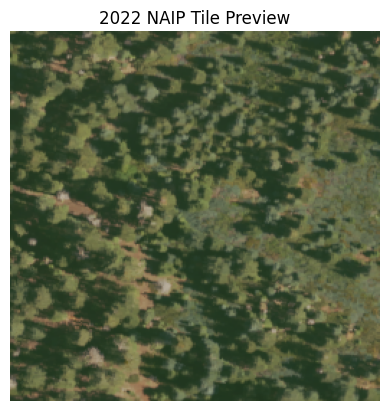

In [ ]:
import matplotlib.pyplot as plt
import rasterio

tif_path = "2022_20220810_tile.tif"

with rasterio.open(tif_path) as src:
    img = src.read([1, 2, 3])  # Read RGB bands
    img = img.transpose(1, 2, 0)  # Convert to HWC format for matplotlib

plt.imshow(img)
plt.title("2022 NAIP Tile Preview")
plt.axis('off')
plt.show()
